# Modelos clasificación de texto - Aproximación **ULMFiT**

Creación de un modelo de clasificación de texto usando la aproximación [ULMFit](https://nlp.fast.ai/) representada en el diagrama siguiente:

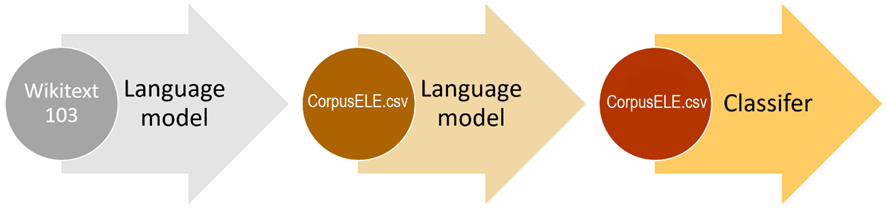

Partimos de  un modelo de lenguaje entrenado con un dataset de tamaño considerable (en nuestro caso la *Wikipedia*). De el se obtienen los fundamentos del lenguaje con el cual se está trabajando. No obstante, es importante que el modelo de clasificación conozca el estilo particular utilizado en los textos que vamos a clasificar y puede no coincidir con el de *Wikipedia*. Es por ello que se realizará un ajuste previo del modelo de lenguaje con nuestros propios datos. En nuestro caso concreto se adecuará a las expresiones de estudiantes de español como lengua extranjera con el dataset CorpusELE.csv que contiene expresiones, redacciones, respuestas, usos, errores, etc de ese tipo de estudiantes y que es completamente diferente al estilo de los textos de la *Wikipedia*.
Así, a partir del modelo de lenguaje inicial obtenemos un nuevo modelo de lenguaje más ajustado a nuestro problema particular y, a partir de el, construiremos nuestro modelo de clasificación.

El modelo de lenguaje inicial, lo obtenemos de la librería FastAI.

# 1.Preparación del entorno

## 1.1.Instalación y carga de ibrerías

Comenzamos actualizando la librería FastAI y descargando la librería datasets de HuggingFace. Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [ ]:
!pip install fastai -Uqq
!pip install datasets -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fastai.text.all import *
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [ ]:
# Instalación de la ayuda de FastAI
!pip install nbdev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.3 MB/s eta 0:00:00


## 1.2.Definición de variables configuración del proceso

In [ ]:
# Constante para la reproducción de resultados aleatorios
seed = 42
# Establecimiento del numero de épocas de entrenamiento (normalmente 10)
nEpochs = 15

# 2.Obtención y análisis del dataset

## 2.1.Carga del Dataset

Para la carga del dataset se ha decidido proceder del modo siguiente:
* Habilitar en Google Drive un directorio para almacenar el dataset ya preprocesado
* Cargar los comandos para poder acceder desde el cuaderno a dicho directorio y cargar el dataset en tiempo de ejecución
* El dataset presenta 46.787 filas con varias características, de las que solo nos son de interés 2 (texto y nivel)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carga del dataset a un pandas
corpus = pd.read_csv('/content/drive/MyDrive/Datos/corpusELE.csv')

## 2.1.Análisis Exploratorio
Se realiza un estudio del contenido del dataset orientado al análisis posterior. Entre los aspectos de interés a considerar se estudia:

* Observación de los datos, tamaño dataset, características
* Verificación no existencia de nulos
* Número de clases existentes (target)
* Número de instancias de cada clase ¿balanceado?
* Longitud del texto y número de palabras para cada clase

In [ ]:
# Mostrar cabecera
corpus.head(5)

,Unnamed: 0,numero,nivel,lenguaM,pClave,frase,archivo
0,0,1.0,A1,Árabe,",","mi familia es solo 3 persona , me madre y me hermano y mi .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
1,3,4.0,B2,Portugués,",","La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
2,6,7.0,A2,Inglés,",","Nos ibe muchas luegos como museos , restaurantes , y parques .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
3,7,8.0,A1,Árabe,",","Entoncés , se puede que llego tarde .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
4,9,10.0,A1,Portugués,",","A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"


In [ ]:
# Tamaño del dataset
print('- Tamaño corpusELE.csv -')
print(f'Número de Filas: {corpus.shape[0]}')
print(f'Número de Columnas: {corpus.shape[1]}')
print(f'Shape: {corpus.shape}')
print('--------------------------')

- Tamaño corpusELE.csv -
Número de Filas: 46787
Número de Columnas: 7
Shape: (46787, 7)
--------------------------


In [ ]:
# Información del dataset
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46787 entries, 0 to 46786
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  46787 non-null  int64  
 1   numero      46787 non-null  float64
 2   nivel       46787 non-null  object 
 3   lenguaM     46787 non-null  object 
 4   pClave      46787 non-null  object 
 5   frase       46787 non-null  object 
 6   archivo     46787 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.5+ MB


In [ ]:
# Diferentes niveles
niveles = corpus['nivel'].unique()
niveles.sort()
niveles

array(['A1', 'A2', 'B1', 'B2', 'C1'], dtype=object)

In [ ]:
# Verificamos que no hay ningún valor null en el dataset
corpus.isnull().sum()

Unnamed: 0    0
numero        0
nivel         0
lenguaM       0
pClave        0
frase         0
archivo       0
dtype: int64

De los resultados de las celdas anteriores podemos concluir que el dataset contiene 46787 filas con 7 características, que no tiene ningún valor nulo y que el detalle de las características es el siguiente:
* **numero**:numero de orden original de la frase en el conjunto de archivos
* **nivel**: Código del nivel de destreza en castellano de acuerdo al marco común europeo. Admite 5 valores posibles: A1, A2, B1, B2 y C1
* **lenguaM**: Lengua materna del estudiante. Campo categórico con los siguientes valores posibles: Chino Mandarín, Francés, Inglés, Portugués, Ruso y Árabe
* **pClave**: Palabra clave de la frase
* **archivo**: Nombre y ubicación del archivo inicial de datos

In [ ]:
# Cuenta de los registros por cada nivel
corpus["nivel"].value_counts()

A2    13926
A1    12284
B1    10848
B2     6601
C1     3128
Name: nivel, dtype: int64

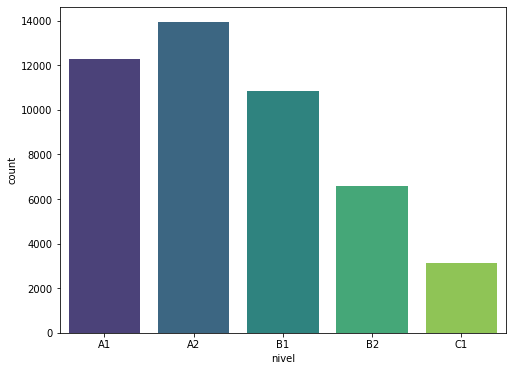

In [ ]:
# Gráfico de barras del número de registros por característica categorica
import seaborn as sb
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='nivel', data=corpus, orient='h', palette='viridis', order =['A1', 'A2', 'B1', 'B2', 'C1'])

## 2.2.Preparación del conjunto de datos
El objeto de esta sección es realizar los ajustes necesarios en el dataset para que pueda ser utilizado por las librerías de FastAI que imnplementan la LSTM. Entre los aspectos a considerar se encuentran:
* Eliminación de las columnas que no son de interés para el problema de clasificación
* Adecuación de las características del dataset.


### 2.2.1.Eliminación características sin interés (para clasificación)

In [ ]:
# Eliminamos del dataset aquellas columnas (características) que no nos son de interés
corpus.drop('numero', inplace=True, axis=1)
corpus.drop('pClave', inplace=True, axis=1)
corpus.drop('archivo', inplace=True, axis=1)
corpus.drop('lenguaM', inplace=True, axis=1)
corpus.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
corpus.head()

,nivel,frase
0,A1,"mi familia es solo 3 persona , me madre y me hermano y mi ."
1,B2,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS ."
2,A2,"Nos ibe muchas luegos como museos , restaurantes , y parques ."
3,A1,"Entoncés , se puede que llego tarde ."
4,A1,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre ."


In [ ]:
corpus.shape

(46787, 2)

In [ ]:
nRegInicial = corpus.shape[0]
nRegInicial

46787

### 2.2.2.Codificación valores únicos de nivel
* Codificación de la variable categórica "nivel" mediante el diccionario de conversión **nivel_mapping** definido en la sección, cuya codificación es la siguiente: **A1** = 0, **A2** = 1, **B1** = 2, **B2** = 3 y **C1** = 4 
* Eliianción de la columna  "nivel". Dejamos solo "label"
* Cambio del nombre de la columna "frase" -> "text" (requisito FastAI)

In [ ]:
# Convertimos la variable "nivel" en numerica ordenada, estableciendo nosotros el orden que queremos de forma similar a OrdinalEncoder
nivel_mapping = {
    'A1' : 0,
    'A2' : 1,
    'B1' : 2,
    'B2' : 3,
    'C1' : 4
}

corpus['label'] = corpus.nivel.map(nivel_mapping)
corpus

,nivel,frase,label
0,A1,"mi familia es solo 3 persona , me madre y me hermano y mi .",0
1,B2,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .",3
2,A2,"Nos ibe muchas luegos como museos , restaurantes , y parques .",1
3,A1,"Entoncés , se puede que llego tarde .",0
4,A1,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .",0
...,...,...,...
46782,B1,Señora Marquez,2
46783,B1,Estimado Señor / Señora,2
46784,B1,sinceramente,2
46785,A1,Sérgio,0


In [ ]:
# Eliminamos la columna nivel (nos quedamos con la codificación en label)
corpus.drop('nivel', inplace=True, axis=1)
corpus

,frase,label
0,"mi familia es solo 3 persona , me madre y me hermano y mi .",0
1,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .",3
2,"Nos ibe muchas luegos como museos , restaurantes , y parques .",1
3,"Entoncés , se puede que llego tarde .",0
4,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .",0
...,...,...
46782,Señora Marquez,2
46783,Estimado Señor / Señora,2
46784,sinceramente,2
46785,Sérgio,0


In [ ]:
# Renombramos la columna "frase" por "text" debido a requerimientos FastAI
corpus= corpus.rename(columns={"frase": "text"})

## 2.2.Segmentación Data Train + Data Test
Disponemos del dataset **corpus** con dos características (label, text) cargado y preparado.

El objeto de esta sección es realizar una segmentación del dataset para separar el conjunto de Train y el de Test, de forma que la validación la podamos hacer con un conjunto de datos sin manipular y con la misma estratificación, para que sea lo más real posible y podamos verificar si se produce Overfitting o no.
Ambos conjuntos ya tienen hechos los preparativos (codificación) y ajuste de los nombres de las características que deberán llevarse a cabo en caso de obtenerse nuevos datos. El cobjunto de Test se reserva para que no se vea afectado por posibles operaciones destinadas al balanceo de clases de forma que el conjunto de test corresponda fielmente a una muestra real, sin manipulación.

La Fragmentación se lleva a cabo con teniendo en cuenta tres aspectos importantes: **Primero**, debe ser estratificada, es decir cada una de las dos partes ha de conservar la proporción de valores de la clase del dataset, **Segundo**, ha de realizar un mezclado aleatorio de los registros y **Tercero** se ha de realizar con las proporciones indicadas (en principio 80% conjunto de Train y 20% conjunto de Test), aunque podrían probarse otras combinaciones.

* Fragmentamos corpus = Train + Test
* Reservamos Test

In [ ]:
from sklearn.model_selection import train_test_split

# Obtener la columna target para establecer la proporción en la segmentación
y1 = corpus['label'].values

# Segmentación Train + Test (80/20, estatificada y reordenación aleatoria)
corpus_train_val, corpus_test = train_test_split(corpus, test_size=0.20, random_state=seed, shuffle=True, stratify = y1)

In [ ]:
# Salvamos el dataset (para poderlo utilizar en caso de que no queramos balanceado)
df0 = corpus_train_val

In [ ]:
# Información Conjunto Train/Val
print(corpus_train_val['label'].value_counts())
print(corpus_train_val.shape[0])

1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
37429


In [ ]:
# Información Conjunto Test
print(corpus_test['label'].value_counts())
print(corpus_test.shape[0])

1    2785
0    2457
2    2170
3    1320
4     626
Name: label, dtype: int64
9358


# 3.Balanceado del Dataset

Vista la distribución de clases del dataset (train_val, porque el conjunto de Test no se ha de tocar), se concluye que están manifiéstamente desbalanceadas, sobre todo en las clases correspondienrtes a los niveles más altos de la clasificación (B2 y C1). Respecto a los niveles más bajos (A1, A2 y B1), se observa que, aún existiendo diferencias de recuento entre ellos, podríamos considerar que se encuentran más o menos balanceados.
Al objeto de determinar si el balanceado de las clases puede afectar al rendimiento del modelo de clasificación, se plantea llevar a cabo un balanceado del mismo siguiendo dos técnicas:
* 1.- Upsampling de las clases minoritarias (B2 y C1) hasta conseguir equipararlas en observaciones a la media de las 3 clases mayoritarias (9.882 observaciones). Esto supone un enorme incremento de las mismas y supondría alterar 3 de las 5 clases (tambíen la B1). Con objeto de alterar lo menos posible los datos reales obtenidos, se decide homologar las clases minoritarias a la más baja de las mayoritarias, es decir B1 con 8.678 observaciones. Ha de tenerse en cuenta que ésta opción, si bien equilibra las clases minoritarias, no es un balanceado perfecto del dataset.

* 2.- En la segunda prueba, lo que buscaremos es homogeneizar el recuento en todas las clases. Para ello emplearemos una técnica mixta que supondrá el mismo upsampling para las clases minoritarias (B2 C1) ya realizado en el caso anterior unido al downsampling de las dos mayoritarias (A1 y A2) hasta homogeneizarlos al recuento de B1. Con ello conseguimos un verdadero balanceado, pero con mayor alteración del conjunto inicial.

Dependiendo de alguna de las actuaciones mejora los resultados obtenidos, podríamos replantearnos la opción de realizar en el caso del oversampling, en vez de la repetición aleatoria de instancias, la sintetización de nuevas instancias

In [ ]:
from sklearn.utils import resample
df = corpus_train_val
# Determinamos el número que determina el balanceado.
# Igualamos al nivel de la clase B1=2 (10848) tanto en Upsampling como Downsampling
regSample = df[df.label==2].shape[0]

## 3.1.Upsamplig Clases minoritarias (df)

In [ ]:
# Fraccionar el dataset, aislando las clases minoritarias: df => dfB2 y dfC1
# Clase B2 = 3
dfB2 = df[df.label==3]
nB2before = dfB2.shape[0]
print(f'Nº registros Inicial clase B2: {nB2before}')
# Clase C1 = 4
dfC1 = df[df.label==4]
nC1before = dfC1.shape[0]
print(f'Nº registros Inicial clase C1: {nC1before}')

Nº registros Inicial clase B2: 5281
Nº registros Inicial clase C1: 2502


In [ ]:
# Realizamos el upsampling de la clase minoritaria  B2:
dfB2plus = resample(dfB2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)
nB2after = dfB2plus.shape[0]
print(f'Clase B2: Nº Registros ANTES: {nB2before} - Nº Registros TRAS Upsampling: {nB2after}')

Clase B2: Nº Registros ANTES: 5281 - Nº Registros TRAS Upsampling: 8678


In [ ]:
# Realizamos el Upsampling de la clase minoritaria  C1:
dfC1plus = resample(dfC1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)
nC1after = dfC1plus.shape[0]
print(f'Clase C2: Nº Registros ANTES: {nC1before} - Nº Registros TRAS Upsampling: {nC1after}')

Clase C2: Nº Registros ANTES: 2502 - Nº Registros TRAS Upsampling: 8678


In [ ]:
# Componemos de nuevo el dataset con las clases minoritarias balanceadas con Upsampling
# Para ello:
# 1.- Eliminamos las filas de las clases a trabajar (B2 = 3 y C1 = 4)
# 2.- Al dataset obtenido le añadimos los dos dataset upsampled
niveles = [3, 4]

print(df.shape)
print(df['label'].value_counts())

for nv in niveles:
  df = df.drop(df[df['label']==nv].index)

df = pd.concat([df, dfB2plus, dfC1plus])
print(df.shape)
print(df['label'].value_counts())

(37429, 2)
1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
(47002, 2)
1    11141
0     9827
2     8678
3     8678
4     8678
Name: label, dtype: int64


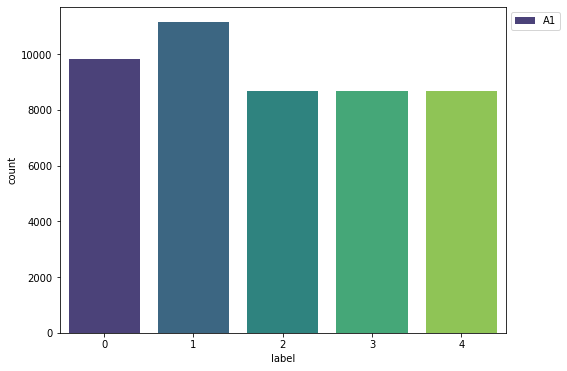

In [ ]:
# Gráfico de barras de registros por característica categorica tras upsampling minoritarias
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='label', data=df, orient='h', palette='viridis', order =[0, 1, 2, 3, 4])
plt.legend(labels = ['A1', 'A2', 'B1', 'B2', 'C1'], loc = 2, bbox_to_anchor = (1,1))

## 3.2.Upsamplig Clases Minoritarias + Downsampling Clases Mayoritarias (df_)

In [ ]:
# Volvemos a tomar el corpus_train_val inicial
df_ = corpus_train_val
# Igualamos al nivel de la clase B1=2 (10848) tanto en Upsampling como Downsampling
regSample = df_[df_.label==2].shape[0]

In [ ]:
# Fraccionar el dataset, aislando todas las clases
df_A1 = df_[df_.label==0]
df_A2 = df_[df_.label==1]
df_B1 = df_[df_.label==2]
df_B2 = df_[df_.label==3]
df_C1 = df_[df_.label==4]

In [ ]:
# Upsampling de la clase minoritaria  B2:
df_B2plus = resample(df_B2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Upsampling de la clase minoritaria  C1:
df_C1plus = resample(df_C1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Downsampling de la clase mayoritaria  A1:
df_A1plus = resample(df_A1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Downsampling de la clase mayoritaria  A2:
df_A2plus = resample(df_A2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Componemos de nuevo el dataset con las clases balanceadas a B1
# Son A1=0, A2=1, B2=3 y C1=4 

niveles = [0, 1, 3, 4]

print(df_.shape)
print(df_['label'].value_counts())

for nv in niveles:
  df_ = df_.drop(df_[df_['label']==nv].index)

df_ = pd.concat([df_A1plus, df_A2plus, df_, df_B2plus, df_C1plus])

print(df_.shape)
print(df_['label'].value_counts())

(37429, 2)
1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
(43390, 2)
0    8678
1    8678
2    8678
3    8678
4    8678
Name: label, dtype: int64


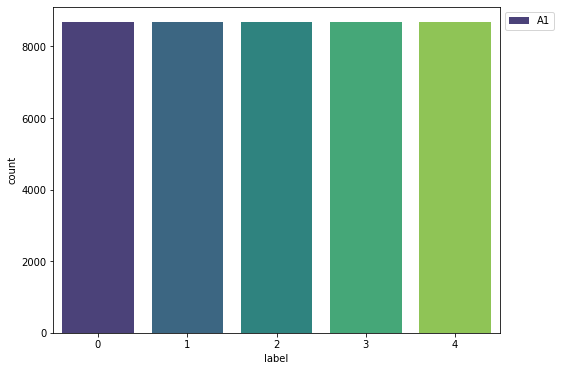

In [ ]:
# Gráfico de barras de registros por característica categorica tras upsampling minoritarias
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='label', data=df_, orient='h', palette='viridis', order =[0, 1, 2, 3, 4])
plt.legend(labels = ['A1', 'A2', 'B1', 'B2', 'C1'], loc = 2, bbox_to_anchor = (1,1))

# 4.Establecer Tipo de Balanceado de datos entrenamiento
Se han creado 3 datasets para poder realizar pruebas:
* **df0**: Dataset sin balancear
* **df**: Dataset semibalanceado (solo upsampling)
* **df_**: Dataset balanceado (upsamplig + downsampling)
Todos ellos son dataset de pruebas, en los que ahora debemos realizar la segmentación train/Validation

In [ ]:
# Para realizar las pruebas, tenemos que dar valor a corpus_train_val con uno de los dataset anteriores.
# Esta opción nos deja a corpus_test totalmente libre para poder realizar la verificación del modelo con datos reales
corpus_train_val=df0

# 5.Segmentación Train + Validation
Realizamos la segmentación del conjunto Train/Val, conservando las proporciones de estratificación existentes en el mismo (puede estar balanceado o no dependiendo del la elección en la sección anterior)
Separados los dos conjuntos, verificamos la correcta segmentación, añadimos una columna que nos permita diferenciarlos y volvemos a componer el conjunto unido (es requerimiento de la biblioteca FastAI)

In [ ]:
# Mantendremos en esta segmentación la estratificación del conjunto base (corpus_train_val)
# Nótese que es diferente dependiendo de el tipo de balanceado y que eso lo determinamos con y2
y2 = corpus_train_val['label'].values
corpus_train, corpus_valid = train_test_split(corpus_train_val, test_size=0.2, random_state=seed, shuffle=True, stratify = y2)

In [ ]:
# Información Conjunto Train
print(corpus_train['label'].value_counts())
print(corpus_train.shape[0])

1    8913
0    7861
2    6942
3    4225
4    2002
Name: label, dtype: int64
29943


In [ ]:
# Información Conjunto Valid
print(corpus_valid['label'].value_counts())
print(corpus_valid.shape[0])

1    2228
0    1966
2    1736
3    1056
4     500
Name: label, dtype: int64
7486


Juntamos ahora nuestro conjunto de entrenamiento y de validación. Para poder diferenciarlos vamos a añadir una columna a cada uno de ellos para indicar al conjunto al que pertenecen. La columna ``set`` va a tener dos valores: True si pertenece al conjunto de validación y False si pertenece al conjunto de test.

In [ ]:
corpus_train['set']=False
corpus_valid['set']=True

In [ ]:
# Juntamos los datasets Train + Validation
corpus_train_val = pd.concat([corpus_train, corpus_valid])
corpus_train_val

,text,label,set
16995,"No , está las palabras cheat_fair .",2,False
28814,Vivimos en un país donde se permite humar cigarrillos y aún se paga altas tasas de impuestos .,3,False
3908,"Por eso , quiero seguir un programa academico en españa para mejorar mis competencias técnicas , comerciales y de compresión de la lengua y cultura españolas en_vista_de encontrar a empresas españolas .",3,False
43512,Puedes hacer guia proximo mes ?,2,False
38237,"Para obtener a visa para estudiar , ¿ necesito obtener un otra visa para trabajar a el mismo tiempo ?",3,False
...,...,...,...
40424,"Buenas tardes , me llamo Bárbara_Cunha y escribo con la intención de reservar una habitacíon para la ultima semana de noviembre de el año 2012 .",1,True
46585,Un abrazo Pedro,0,True
12229,"Soy simpatica y amable . tengo el pelo liso y largo , tengo los ojos marrones .",0,True
9750,su enfadado cliente .,4,True


In [ ]:
# Información Conjunto Train/Val
print(corpus_train_val['label'].value_counts())
print(corpus_train_val.shape[0])
print(corpus_train_val.shape)

1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
37429
(37429, 3)


In [ ]:
# Obtener información sobre cualquier función de fastAI
# Para que se vea mejor hay que instalar previamente
# pip install nbdev
doc(ClassificationInterpretation.from_learner)

# 6.El Modelo de lenguaje (LM)

El proceso a seguir para hacer fine-tuning sobre el modelo de lenguaje de FastAI es análogo al visto en prácticas anteriores. Comenzamos creando un `DataBlock` a partir de nuestro dataframe. 

## 6.1.Creación DataBlock (LM)

In [ ]:
%%time
db_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True, max_vocab=100000), # Indicamos que vamos a trabajar con un modelo de lenguaje
    get_items=ColReader('text'), # Indicamos donde estará el texto dentro del dataframe
    splitter=RandomSplitter(0.2, seed = seed) # Partimos el dataset en entrenamiento y validación y lo hacemos repetible fijando la semilla.
)

CPU times: user 6.55 s, sys: 2.05 s, total: 8.61 s
Wall time: 15.2 s


## 6.2.Creación Dataloader (LM)
Creamos ahora nuestro `dataloader` (esto puede llevar varios segundos).

In [ ]:
%%time
dls_lm = db_lm.dataloaders(corpus_train_val, bs=128, seq_len=80)

CPU times: user 26.6 s, sys: 506 ms, total: 27.1 s
Wall time: 26.9 s


Podemos ahora mostrar un batch de este `dataloader`. Como podemos apreciar, la entrada del modelo es una frase, y la salida es dicha frase desplazada una posición a la derecha.

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxunk mi nuevos amigos xxbos xxmaj xxunk es una persona un_poco nerviosa como pudemos veer la fina de el mundial de el año 2006 cuando xxunk el jugador de xxmaj italia . xxbos xxmaj se llaman gemelas . xxbos xxmaj era conocido por ser un piloto muy rápido y con un estilo muy agresivo , que no era xxunk por sus compañeros , también porque era un hombre que hacia mucho ejercicio xxunk . xxbos xxmaj es muy limpio","xxunk mi nuevos amigos xxbos xxmaj xxunk es una persona un_poco nerviosa como pudemos veer la fina de el mundial de el año 2006 cuando xxunk el jugador de xxmaj italia . xxbos xxmaj se llaman gemelas . xxbos xxmaj era conocido por ser un piloto muy rápido y con un estilo muy agresivo , que no era xxunk por sus compañeros , también porque era un hombre que hacia mucho ejercicio xxunk . xxbos xxmaj es muy limpio y"
1,"para mi e lucha por todo en que xxunk . xxbos xxmaj puede contactar me por las mañanas por teléfono . xxbos ¡ xxmaj hasta luego ¡ xxbos xxmaj ello hace un asado muy bueno y todos los dias bebe una cerveza . xxbos xxmaj todos tienen el derecho de ser xxunk y el gobierno debe proteger lo por no permitir el fumar en los lugares públicos . xxbos xxmaj mi amigo mejor era una chica de xxmaj austria ,","mi e lucha por todo en que xxunk . xxbos xxmaj puede contactar me por las mañanas por teléfono . xxbos ¡ xxmaj hasta luego ¡ xxbos xxmaj ello hace un asado muy bueno y todos los dias bebe una cerveza . xxbos xxmaj todos tienen el derecho de ser xxunk y el gobierno debe proteger lo por no permitir el fumar en los lugares públicos . xxbos xxmaj mi amigo mejor era una chica de xxmaj austria , su"


## 6.3.Creación del modelo (LM)
Creamos ahora nuestro Modelo de Lenguaje (basado en AWD_LSTM) `Learner`.

In [ ]:
callbacks = [ShowGraphCallback(), SaveModelCallback()]  # Mostrar grafica con las curvas de entrenamiento y validacion y guardar el mejor modelo del entrenamiento

learn = language_model_learner(
    dls_lm, # El dataloader que usamos
    AWD_LSTM, # La arquitectura que es la misma usada en la práctica anterior
    drop_mult=0.3, # Aplicamos dropout para evitar el sobreajuste
    metrics=[accuracy, Perplexity()], # Como métricas usamos la accuracy y la perplexity.
    cbs=callbacks
).to_fp16()


## 6.4.Entrenamiento del modelo (LM)

### 6.4.1.Determinación del Learning Rate (LM)

CPU times: user 1min 14s, sys: 960 ms, total: 1min 15s
Wall time: 1min 19s


SuggestedLRs(valley=0.0063095735386013985)

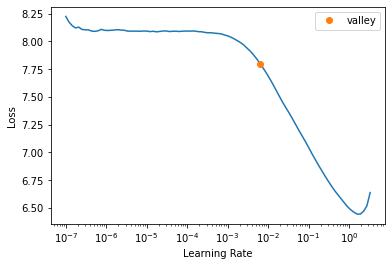

In [ ]:
# Obtenemos el learning rate más adecuado
%%time
learn.lr_find()

### 6.4.2.Ajuste fino del modelo (LM)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.172908,4.744682,0.237134,114.971275,00:44


Better model found at epoch 0 with valid_loss value: 4.744682312011719.


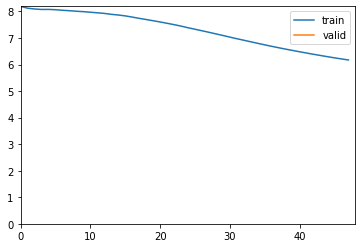

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.690650,4.428271,0.269718,83.786446,00:45
1,4.501603,4.180588,0.281668,65.404312,00:45
2,4.271393,3.951991,0.296086,52.038876,00:45
3,4.052318,3.786898,0.307774,44.119347,00:46
4,3.853981,3.682863,0.313493,39.760044,00:46
5,3.691382,3.627191,0.318801,37.607040,00:44
6,3.563003,3.590942,0.320471,36.268230,00:45
7,3.444644,3.573442,0.322775,35.639069,00:44
8,3.351405,3.555640,0.325241,35.010235,00:43
9,3.277094,3.547932,0.325707,34.741386,00:44


Better model found at epoch 0 with valid_loss value: 4.428271293640137.


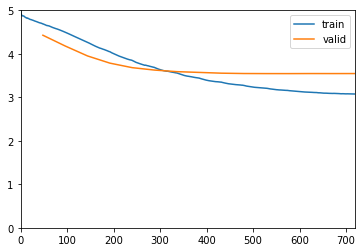

Better model found at epoch 1 with valid_loss value: 4.180588245391846.
Better model found at epoch 2 with valid_loss value: 3.951991081237793.
Better model found at epoch 3 with valid_loss value: 3.786898374557495.
Better model found at epoch 4 with valid_loss value: 3.6828625202178955.
Better model found at epoch 5 with valid_loss value: 3.6271913051605225.
Better model found at epoch 6 with valid_loss value: 3.590942144393921.
Better model found at epoch 7 with valid_loss value: 3.5734424591064453.
Better model found at epoch 8 with valid_loss value: 3.555640459060669.
Better model found at epoch 9 with valid_loss value: 3.547931671142578.
Better model found at epoch 10 with valid_loss value: 3.546213150024414.
Better model found at epoch 11 with valid_loss value: 3.545855760574341.
CPU times: user 12min, sys: 5.85 s, total: 12min 6s
Wall time: 12min 8s


In [ ]:
%%time
learn.fine_tune(nEpochs, base_lr= 6.3e-3)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.32679277658462524.


(#3) [3.545855760574341,0.32679277658462524,34.669342041015625]

### 6.4.3.Almacenamiento del modelo (LM)
Una vez entrenado el modelo guardamos el `encoder` que usaremos luego para nuestro modelo de clasificación

In [ ]:
# Establecer el directorio en el que se guarde el modelo y el nombre (siempre sin extensión) y guardarlo
# path ='/content/drive/MyDrive/Modelos01/'
# model_name = path+'finetuned95-05-02-128'
# model_name
# learn.save_encoder(f'{model_name}')

'/content/drive/MyDrive/Modelos01/finetuned95-05-02-128'

In [ ]:
# Guardamos el encoder con el mejor modelo
learn.save_encoder('finetuned')

# 7.El Modelo de Clasificación (CM)

Pasamos ahora a crear nuestro modelo de clasificación de texto.
El proceso será similar al anterior ejercicio, pero antes de empezar a entrenar el modelo cargaremos el `encoder` guardado en el paso anterior.

## 7.1.Creación del DataBlock (CM)

In [ ]:
languageLevel_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), CategoryBlock), # La entrada del modelo es texto usando el mismo vocabulario que en el modelo de lenguaje, y la salida una clase 
    get_x=ColReader('text'),  # Indicamos donde estará el texto dentro del dataframe
    get_y=ColReader('label'), # Indicamos cómo extraer la clase del dataframe
    splitter=ColSplitter('set') # Partimos el dataset en entrenamiento y validación
)

## 7.2.Creación del Dataloader (CM)

In [ ]:
%%time
dls_clas = languageLevel_clas.dataloaders(corpus_train_val, bs=64)

CPU times: user 4.23 s, sys: 351 ms, total: 4.58 s
Wall time: 15.7 s


Podemos mostrar un batch de nuestro dataloader. 

In [ ]:
dls_clas.show_batch(max_n=2)

,text,category
0,"xxbos xxup xxunk xxup ver xxup te , xxup porque xxup no xxup viene xxup aca xxup en xxup casa y xxup cena xxup con xxup nosotros xxup estamos xxup haciendo xxup xxunk xxup xxunk xxup una xxup xxunk xxup de xxup vino xxup para xxup comemorar xxup la xxup vuelta xxup de xxup mama xxup di xxup me xxup algo xxup estarei xxup aca xxup esperando xxup te …",0
1,"xxbos xxmaj el contexto pasa durante el año de xxunk , en la xxmaj españa xxunk de xxmaj xxunk , donde los personajes principales xxmaj ofelia y su madre fueron a vivir con el padrastro de xxmaj ofelia en una base militar de el gobierno .",4


## 7.3.Creación del modelo (CM)
Pasamos ahora a crear nuestro `learner` usando el método `text_classifier_learner` al que pasamos como arquitectura de red la arquitectura [AWD_LSTM](https://arxiv.org/abs/1708.02182), además aplicamos dropout a nuestro modelo. 

### 7.3.1.Definición de métricas (CM)

In [ ]:
# Definir instancias de objetos para diferentes métricas (predefinicas en fastai)

recall_score = Recall(average ='weighted')
precision_score = Precision(average ='weighted')
#f1_score = F1Score(average ='weighted')
metrics = [accuracy, precision_score, recall_score]

### 7.3.2.Establecimiento de Callbacks (CM)

In [ ]:
callbacks = [ShowGraphCallback(),
             SaveModelCallback(),
             EarlyStoppingCallback(patience=5),               # Parada anticipada si en 3 epoch no mejora la pérdida
             ReduceLROnPlateau(patience = 1, min_lr = 1e-8)]

### 7.3.3.Creación del modelo (CM)

In [ ]:
# Establecer el encoder del mejor modelo : BS=128, DO=0,2 y Proporción 95/05
# que está almacenado en finetuned95-05-02
# path ='/content/drive/MyDrive/Modelos01/'
# model_name = path+'finetuned95-05-02'
# model_name

In [ ]:
learnClass = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=metrics, cbs=callbacks).to_fp16()

In [ ]:
# Carga del encoder del modelo de lenguaje
learnClass = learnClass.load_encoder('finetuned')
# learnClass = learnClass.load_encoder(f'{model_name}')


## 7.4.Entrenamiento del modelo (CM)

### 7.4.1.Determinación del Learning Rate (CM)

SuggestedLRs(valley=0.0030199517495930195)

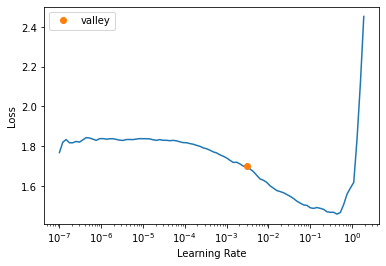

In [ ]:
learnClass.lr_find()

### 7.4.2.Ajuste fino del modelo (CM)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.105819,0.903021,0.636789,0.634752,0.636789,00:43


Better model found at epoch 0 with valid_loss value: 0.9030206203460693.


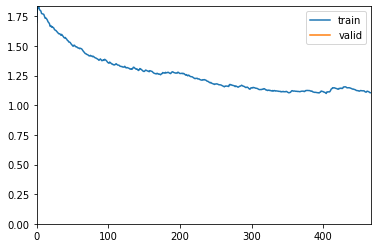

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.987823,0.810428,0.674325,0.676256,0.674325,00:47
1,0.941244,0.784633,0.689420,0.691205,0.689420,00:48
2,0.868038,0.758763,0.699305,0.700173,0.699305,00:47
3,0.767788,0.736147,0.716003,0.720254,0.716003,00:47
4,0.762921,0.757241,0.711595,0.710782,0.711595,00:49
5,0.753654,0.723484,0.724820,0.724173,0.724820,00:47
6,0.698107,0.709435,0.734170,0.736264,0.734170,00:47
7,0.667356,0.704391,0.732701,0.734191,0.732701,00:49
8,0.632169,0.687516,0.739514,0.741102,0.739514,00:47
9,0.613132,0.695133,0.742052,0.741680,0.742052,00:47


Better model found at epoch 0 with valid_loss value: 0.8104283809661865.


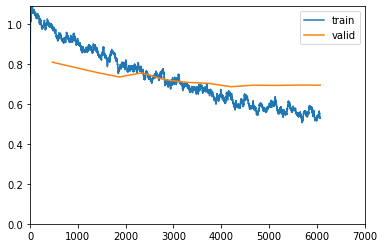

Better model found at epoch 1 with valid_loss value: 0.7846328020095825.
Better model found at epoch 2 with valid_loss value: 0.7587634325027466.
Better model found at epoch 3 with valid_loss value: 0.7361471056938171.
Epoch 4: reducing lr to 0.00014966669829370342
Better model found at epoch 5 with valid_loss value: 0.7234842777252197.
Better model found at epoch 6 with valid_loss value: 0.7094348073005676.
Better model found at epoch 7 with valid_loss value: 0.7043912410736084.
Better model found at epoch 8 with valid_loss value: 0.6875156164169312.
Epoch 9: reducing lr to 6.967544715117678e-05
Epoch 10: reducing lr to 4.7804001153814964e-05
Epoch 11: reducing lr to 2.8371319173094763e-05
Epoch 12: reducing lr to 1.3104072132601999e-05
Epoch 13: reducing lr to 3.358840737778968e-06
No improvement since epoch 8: early stopping
CPU times: user 4min 3s, sys: 9.68 s, total: 4min 13s
Wall time: 11min 59s


In [ ]:
%%time
learnClass.fine_tune(15, 3.01e-3)

In [ ]:
learnClass.validate()

Better model found at epoch 0 with valid_loss value: 0.7395137548446655.


(#4) [0.6875156164169312,0.7395137548446655,0.7411016529756216,0.7395137590168315]

### 7.4.3.Predicción (CM)

In [ ]:
# Parece que a Cervantes lo trata bien y le asigna un C1 ;-)
learnClass.predict('En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho que vivia un hidalgo')

('2', tensor(2), tensor([0.0693, 0.0861, 0.7159, 0.0019, 0.1267]))

In [ ]:
# Catalogada como A1 de estudiante Portugues
learnClass.predict('A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre.')

('0',
 tensor(0),
 tensor([9.9355e-01, 5.5989e-03, 7.3658e-04, 4.1393e-05, 6.9320e-05]))

In [ ]:
# Lenguaje tipo indio
learnClass.predict('La proxima semana hay un otro examen')

('1', tensor(1), tensor([0.3621, 0.5346, 0.0906, 0.0095, 0.0032]))

## 7.5.Validación del modelo (CM)

### 7.5.1.Construcción del conjunto de Test

In [ ]:
corpus_test['set']=True
corpus_train_test = pd.concat([corpus_train, corpus_test])
corpus_train_test = corpus_train_test.rename(columns={"frase": "text"})
dls_test = languageLevel_clas.dataloaders(corpus_train_test, bs=32)

### 7.5.2.Validación

In [ ]:
learnClass.dls = dls_test
learnClass.validate()

Better model found at epoch 0 with valid_loss value: 0.7342380881309509.


(#4) [0.6903192400932312,0.7342380881309509,0.7349016418337425,0.7342380850609105]

### 7.5.3.Matriz de confusión modelo

In [ ]:
# Obtener la matriz de confusión. Mediante un objeto "interp"
interp_test = ClassificationInterpretation.from_learner(learnClass)

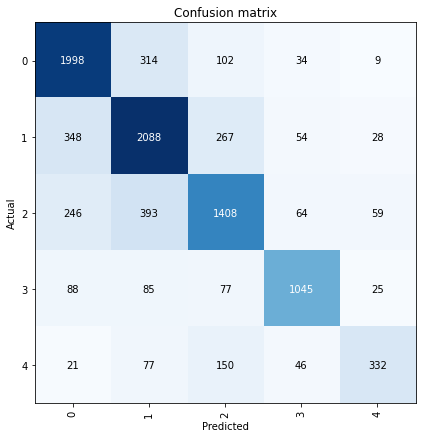

In [ ]:
# Matriz de Confusión sobre el conjunto de test (corpus_train_test[set=True])
interp_test.plot_confusion_matrix(figsize =(10,6))